In [1]:
!pip install --upgrade seaborn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install --upgrade scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 38.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:

# import values
import os
import zipfile
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
from datetime import datetime
from pathlib import Path
import joblib


from sklearn.preprocessing import (StandardScaler, MinMaxScaler, 
                                  OneHotEncoder, OrdinalEncoder)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import (silhouette_score, davies_bouldin_score, 
                            calinski_harabasz_score, adjusted_rand_score,
                            normalized_mutual_info_score)

from pandas.plotting import parallel_coordinates

warnings.filterwarnings('ignore')

In [4]:

# Configuration class
class Config:
    
    # Parameter value
    TARGET_COL = 'y'  
    TEST_SIZE = 0.2  
    VAL_SIZE = 0.1    
    
    BATCH_SIZE = 64
    EPOCHS = 100
    PATIENCE = 10
    LEARNING_RATE = 0.001
    
    BASE_DIR = Path.cwd()
    MODEL_DIR = BASE_DIR/'models'
    DATA_DIR = BASE_DIR/'data'
    LOG_DIR = BASE_DIR/'logs'
    FIG_DIR = BASE_DIR/'figures'
    
    @classmethod
    def create_dirs(cls):
        for dir_path in [cls.MODEL_DIR, cls.DATA_DIR, cls.LOG_DIR, cls.FIG_DIR]:
            dir_path.mkdir(exist_ok=True, parents=True)

Config.create_dirs()

np.random.seed(42)



def copying_financial_data():
    """Copying financial_data"""
    data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
    try:
        print("Copying financial data from UCI repository...")
        request_data = requests.get(data_url)
        request_data.raise_for_status()
        
        # Saving the file
        with open("temp_bank_data.zip", "wb") as f:
            f.write(request_data.content)
        #ZIP-FILE
        with zipfile.ZipFile("temp_bank_data.zip", 'r') as zip_ref:
            csv_f = [f for f in zip_ref.namelist() if f.endswith('.csv')][0]
            with zip_ref.open(csv_f) as f:
                content = f.read().decode('utf-8')
                df = pd.read_csv(StringIO(content), sep=';')
        
        os.remove("temp_bank_data.zip")
        
        print("df.shape", df.shape)
        return df
        
    except Exception as e:
        print(f"Not able to copy it {str(e)}")
        return None


def initiating_financial_data():
    """Load financial data"""
    cache_path = Config.DATA_DIR/'processed_financial_data.pkl'
    
    if cache_path.exists():
        return joblib.load(cache_path)
    
    # load real data 
    df = copying_financial_data()
    

    # processing
    if 'Transaction_Date' in df.columns:
        df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'])
        df.set_index('Transaction_Date', inplace=True)
    else:
        df = df.reset_index(drop=True)
    
    # missing values
    imputer = SimpleImputer(strategy='median')
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    if numeric_cols:
        df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    

    if 'Transaction_Amount' in df.columns:
        df['Transaction_Volume'] = df['Transaction_Amount'] * df.groupby('Customer_ID')['Transaction_Amount'].transform('count')
    if 'Account_Balance' in df.columns and 'Income' in df.columns:
        df['Balance_to_Income_Ratio'] = df['Account_Balance'] / df['Income']
    if 'age' in df.columns: 
        
        df['Age_Group'] = pd.cut(df['age'], bins=[0, 30, 50, 70, 100], labels=['Young', 'Adult', 'Senior', 'Elderly'])
    
    joblib.dump(df, cache_path)
    
    return df


def eda_anaylsis(df):
    """eda_anaylsis"""
    
    # Information
    display(df.head())
    print(f"\ndf.shape: {df.shape}")
    print(df.dtypes)
    print(df.isnull().sum())
    
    # Distributions of numeral
    numeric_features = df.select_dtypes(include=np.number).columns.tolist()
    if numeric_features:
        plt.figure(figsize=(15, 10))
        for i, col in enumerate(numeric_features[:6], 1):  
            plt.subplot(2, 3, i)
            sns.histplot(df[col], kde=True)
            plt.title(f'Distribution of {col}')
            plt.grid(True)
        plt.tight_layout()
        plt.savefig(Config.FIG_DIR/'numeric_distributions.png', dpi=300)
        plt.show()
    
    # Categorical features
    categorical_features = df.select_dtypes(include='object').columns.tolist()
    if categorical_features:
        plt.figure(figsize=(15, 10))
        for i, col in enumerate(categorical_features[:4], 1): 
            plt.subplot(2, 2, i)
            sns.countplot(data=df, y=col, order=df[col].value_counts().iloc[:10].index)  
            plt.title(f'Distribution of {col}')
        plt.tight_layout()
        plt.savefig(Config.FIG_DIR/'categorical_distributions.png', dpi=300)
        plt.show()
    
    # Correlation Stats
    if len(numeric_features) > 1:
        plt.figure(figsize=(12, 8))
        sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix of Financial Metrics')
        plt.tight_layout()
        plt.savefig(Config.FIG_DIR/'correlation_matrix.png', dpi=300)
        plt.show()


def financial_data_processing(df):
    """financial_data_processing"""
    categorical_features = df.select_dtypes(include='object').columns.tolist()
    numeric_features = df.select_dtypes(include=np.number).columns.tolist()
    
    if Config.TARGET_COL in categorical_features:
        categorical_features.remove(Config.TARGET_COL)
    if Config.TARGET_COL in numeric_features:
        numeric_features.remove(Config.TARGET_COL)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='drop'
    )
    
    X = df.drop(Config.TARGET_COL, axis=1, errors='ignore')
    X_scaled = preprocessor.fit_transform(X)
    
    numeric_feature_names = numeric_features
    categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    feature_names = list(numeric_feature_names) + list(categorical_feature_names)
    
    return X_scaled, feature_names, preprocessor


def clusters_value(X_scaled, max_clusters=10):
    """clusters_value"""
    
    inertia = []
    for k in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters+1), inertia, marker='o')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.savefig(Config.FIG_DIR/'elbow_method.png', dpi=300)
    plt.show()
    
    silhouette_scores = []
    for k in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        silhouette_scores.append(score)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o', color='green')
    plt.title('Silhouette Scores for Various k')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.savefig(Config.FIG_DIR/'silhouette_scores.png', dpi=300)
    plt.show()

    optimal_k = np.argmax(silhouette_scores) + 2 
    print(f"\noptimal_k: {optimal_k}")
    return optimal_k

def cluster_implement(X_scaled, optimal_k):
    """cluster_implemen"""
    results = {}
    
    # K-Means 
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    results['kmeans'] = {'model': kmeans, 'labels': kmeans_labels}
    
    # Clustering 
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X_scaled)
    distances, _ = nbrs.kneighbors(X_scaled)
    distances = np.sort(distances[:, 1], axis=0)
    
    # K-distance 
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.title('k-Distance Graph for DBSCAN')
    plt.xlabel('Points sorted by distance')
    plt.ylabel('Distance to nearest neighbor')
    plt.grid(True)
    plt.savefig(Config.FIG_DIR/'dbscan_kdistance.png', dpi=300)
    plt.show()
    
    eps = distances[int(len(distances)*0.95)] 
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_scaled)
    results['dbscan'] = {'model': dbscan, 'labels': dbscan_labels}
    
    #Clustering
    linked = linkage(X_scaled, method='ward')
    results['hierarchical'] = {'linkage': linked}
    
    #nModels
    gmm = GaussianMixture(n_components=optimal_k, random_state=42)
    gmm_labels = gmm.fit_predict(X_scaled)
    results['gmm'] = {'model': gmm, 'labels': gmm_labels}
    
    return results

def clusters_examing(X_scaled, clustering_results, true_labels=None):
    """clusters_examing"""
    
    evaluation = {}
    
    for algo, result in clustering_results.items():
        if algo == 'hierarchical':
            continue
            
        labels = result['labels']
        
        if algo == 'dbscan' and len(np.unique(labels)) < 2:
            print({len(np.unique(labels))})
            continue
        
        # Internal metrics
        evaluation[algo] = {
            'silhouette_score': silhouette_score(X_scaled, labels),
            'davies_bouldin_score': davies_bouldin_score(X_scaled, labels),
            'calinski_harabasz_score': calinski_harabasz_score(X_scaled, labels)
        }
        
        if true_labels is not None:
            evaluation[algo].update({
                'adjusted_rand_score': adjusted_rand_score(true_labels, labels),
                'normalized_mutual_info': normalized_mutual_info_score(true_labels, labels)
            })
    
    # Evaluation results
    eval_df = pd.DataFrame(evaluation).T
    display(eval_df)
    
    return evaluation



def clusters_view(X_scaled, clustering_results, feature_names, df):
    """Visualize_cluster"""
    
    # Dimensionality visualization
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    
    for algo, result in clustering_results.items():
        if algo == 'hierarchical':
            plt.figure(figsize=(15, 7))
            dendrogram(result['linkage'], truncate_mode='level', p=3)
            plt.title('Hierarchical Clustering Dendrogram')
            plt.xlabel('Sample Index or (Cluster Size)')
            plt.ylabel('Distance')
            plt.savefig(Config.FIG_DIR/f'{algo}_dendrogram.png', dpi=300)
            plt.show()
            continue
            
        labels = result['labels']
        
        if algo == 'dbscan' and len(np.unique(labels)) < 2:
            continue
        
        # PCA 
        pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
        pca_df['Cluster'] = labels
        
        plt.figure(figsize=(10, 8))
        sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', alpha=0.7)
        plt.title(f'PCA of {algo.upper()} Clusters')
        plt.savefig(Config.FIG_DIR/f'{algo}_pca.png', dpi=300)
        plt.show()
        
        # t-SNE 
        tsne_df = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
        tsne_df['Cluster'] = labels
        
        plt.figure(figsize=(10, 8))
        sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='Cluster', palette='viridis', alpha=0.7)
        plt.title(f't-SNE of {algo.upper()} Clusters')
        plt.savefig(Config.FIG_DIR/f'{algo}_tsne.png', dpi=300)
        plt.show()
        
        # K-Means
        if algo == 'kmeans':
            # Cluster labels 
            df['Cluster'] = labels
            
            # Cluster
            key_features = ['age', 'balance', 'duration'] if 'age' in df.columns else ['Transaction_Amount', 'Account_Balance', 'Age']
            key_features = [f for f in key_features if f in df.columns]
            
            if key_features:
                plt.figure(figsize=(15, 5))
                for i, feature in enumerate(key_features[:3], 1):
                    plt.subplot(1, 3, i)
                    sns.boxplot(data=df, x='Cluster', y=feature)
                    plt.title(f'{feature} by Cluster')
                plt.tight_layout()
                plt.savefig(Config.FIG_DIR/'cluster_profiles.png', dpi=300)
                plt.show()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,Age_Group
0,56.0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Senior
1,57.0,services,married,high.school,unknown,no,no,telephone,may,mon,...,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Senior
2,37.0,services,married,high.school,no,yes,no,telephone,may,mon,...,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Adult
3,40.0,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Adult
4,56.0,services,married,high.school,no,no,yes,telephone,may,mon,...,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Senior



df.shape: (41188, 22)
age                float64
job                 object
marital             object
education           object
default             object
housing             object
loan                object
contact             object
month               object
day_of_week         object
duration           float64
campaign           float64
pdays              float64
previous           float64
poutcome            object
emp.var.rate       float64
cons.price.idx     float64
cons.conf.idx      float64
euribor3m          float64
nr.employed        float64
y                   object
Age_Group         category
dtype: object
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m

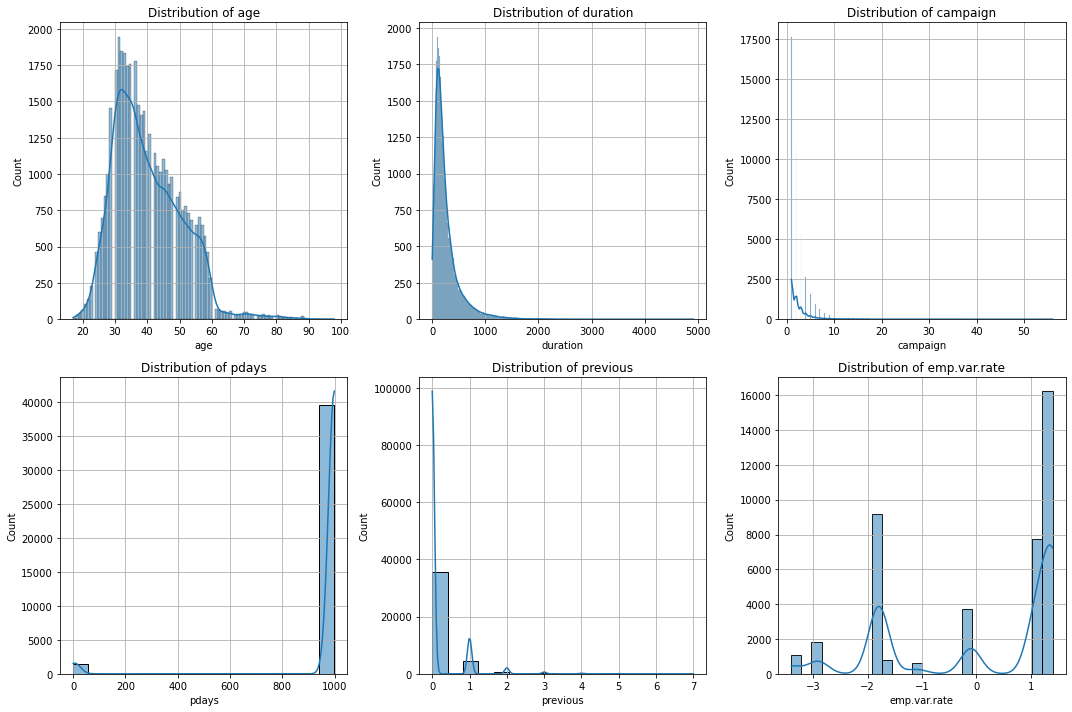

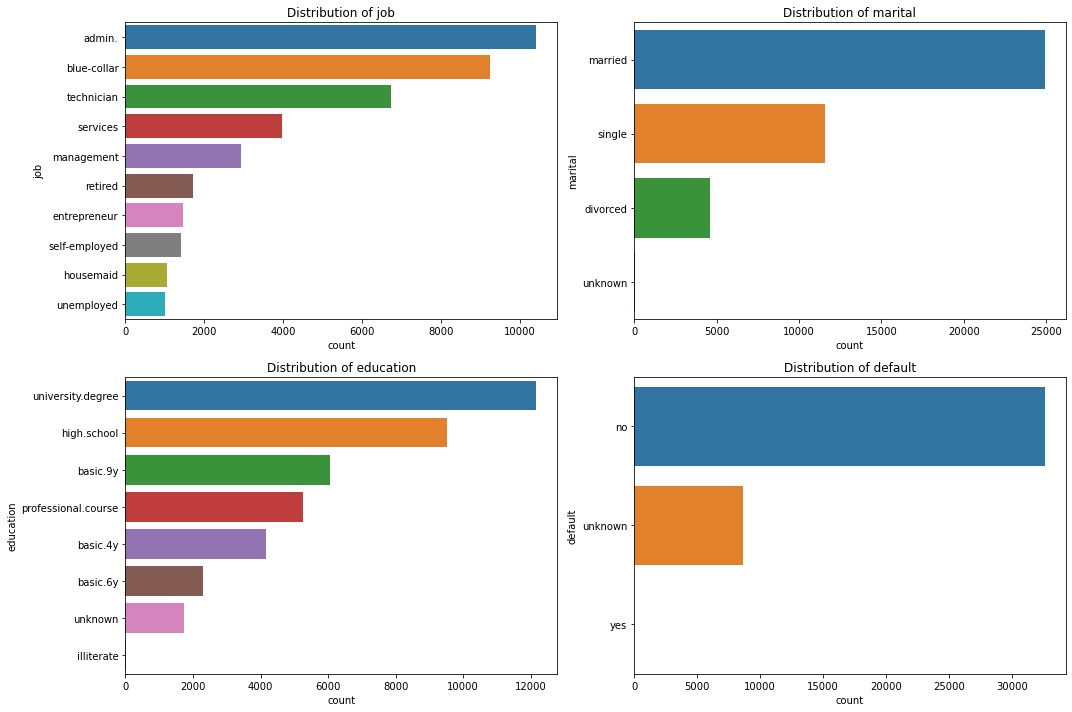

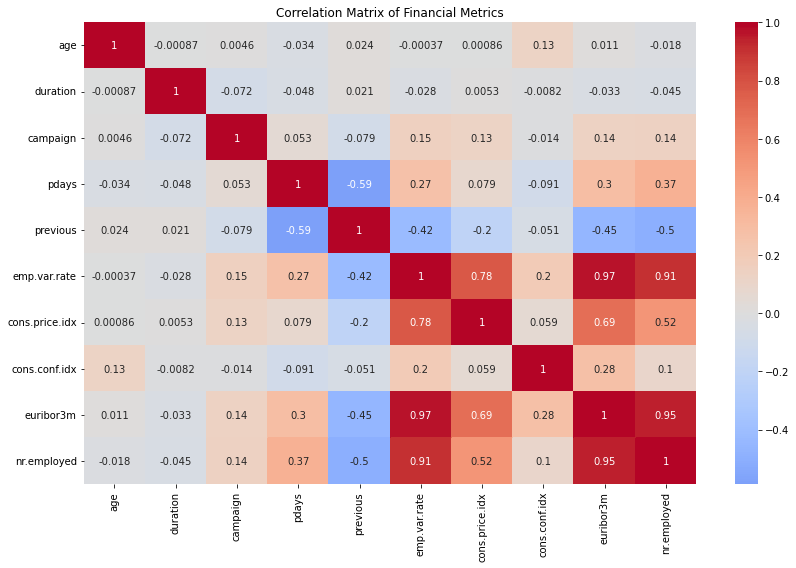


=== DATA PREPROCESSING ===


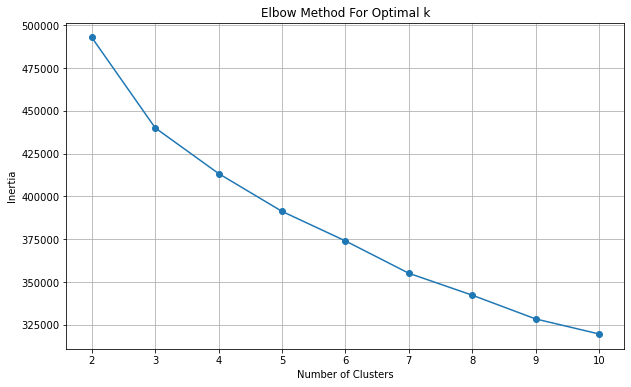

In [ ]:

if __name__ == "__main__":
    # 1. Loading Data
    df = initiating_financial_data()
    
    # Perform EDA
    eda_anaylsis(df)
    
    # 3.Preparing data for clustering
    print("\n=== DATA PREPROCESSING ===")
    X_scaled, feature_names, preprocessor = financial_data_processing(df)
    
    # 4. Optimal Clusters count
    optimal_k = clusters_value(X_scaled)
    
    # Clustering algorithms
    clustering_results = cluster_implemen(X_scaled, optimal_k)
    
    # 6. Evaluate clusters
    true_labels = df[Config.TARGET_COL].values if Config.TARGET_COL in df.columns else None
    evaluation_results = clusters_examing(X_scaled, clustering_results, true_labels)
    
    # 7. Visualize clusters
    clusters_view(X_scaled, clustering_results, feature_names, df)
    
    # 8. Results
    if 'kmeans' in clustering_results:
        df['Cluster'] = clustering_results['kmeans']['labels']
    df.to_csv(Config.DATA_DIR/'financial_clustering_results.csv', index=True)
    
    print(f"Results saved to {Config.DATA_DIR/'financial_clustering_results.csv'}")